In [ ]:
import pandas as pd
import numpy as np
import optuna
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def convert_timedelta_to_seconds(df : pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.timedelta64):
            df[col] = df[col].dt.total_seconds()
    return df

In [333]:
# Load and prepare data
season_df = pd.read_pickle('season_full_dataset.pkl')
season_df = season_df.replace([np.inf, -np.inf], np.nan)
season_df = season_df.dropna()
season_df = convert_timedelta_to_seconds(season_df)

In [334]:
track_df = season_df.copy()
track_df['LapNumber'] = season_df.groupby(['Driver', 'Track'], sort=False).cumcount() + 1
track_df

,Track,Driver,Compound,TyreLife,StartFuel,FCL,LapTime,SpeedI1,SpeedI2,SpeedFL,SumLonAcc,SumLatAcc,MeanLapSpeed,LonDistanceDTW,LatDistanceDTW,LapNumber
0,Bahrain,VER,SOFT,4.0,100.000000,96.019000,99.019,232.0,231.0,278.0,561.07970,840.76762,185.815557,12.072970,16.422290,1
1,Bahrain,VER,SOFT,5.0,98.232143,95.000517,97.974,227.0,238.0,278.0,515.23100,855.49170,196.531157,11.740397,17.690049,2
2,Bahrain,VER,SOFT,7.0,94.696429,95.108589,97.976,228.0,238.0,278.0,512.35496,853.49005,197.711395,11.392580,17.845079,3
3,Bahrain,VER,SOFT,9.0,91.160714,95.224660,97.986,229.0,239.0,279.0,506.39443,798.17038,197.696016,11.075037,15.948652,4
4,Bahrain,VER,SOFT,10.0,89.392857,95.312696,98.021,230.0,239.0,279.0,503.46019,818.31458,197.638955,11.201066,16.233708,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19502,Abu Dhabi,MAG,HARD,31.0,9.684211,90.128421,90.445,290.0,305.0,207.0,467.16149,1002.95167,207.503026,10.856932,27.158910,40
19503,Abu Dhabi,MAG,HARD,32.0,7.947368,89.942526,90.207,288.0,298.0,208.0,478.42989,986.54518,209.047495,17.515440,23.604216,41
19504,Abu Dhabi,MAG,HARD,33.0,6.210526,90.039631,90.252,286.0,299.0,210.0,477.92455,1002.83513,210.261800,12.364026,21.478274,42
19505,Abu Dhabi,MAG,HARD,34.0,4.473684,90.268736,90.429,287.0,306.0,209.0,474.41930,1013.42592,212.143581,10.556453,20.259695,43


In [335]:
X = season_df.drop(columns=['LapTime', 'FCL'])
y = season_df['LapTime']

C:\Users\Patryk\AppData\Local\Temp\ipykernel_11516\983413460.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[col]) or X[col].nunique() < 10:


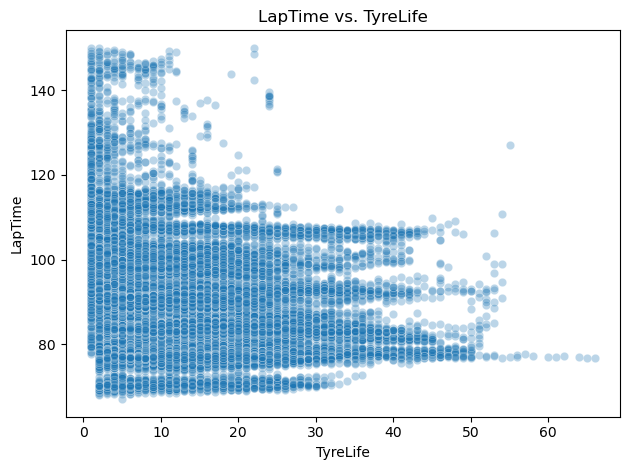

C:\Users\Patryk\AppData\Local\Temp\ipykernel_11516\983413460.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[col]) or X[col].nunique() < 10:


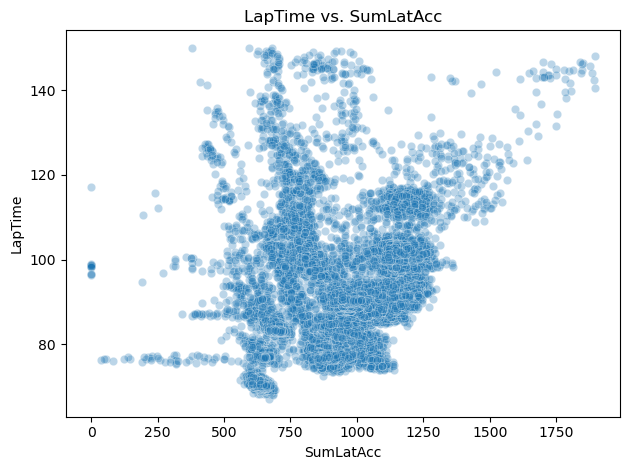

C:\Users\Patryk\AppData\Local\Temp\ipykernel_11516\983413460.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[col]) or X[col].nunique() < 10:


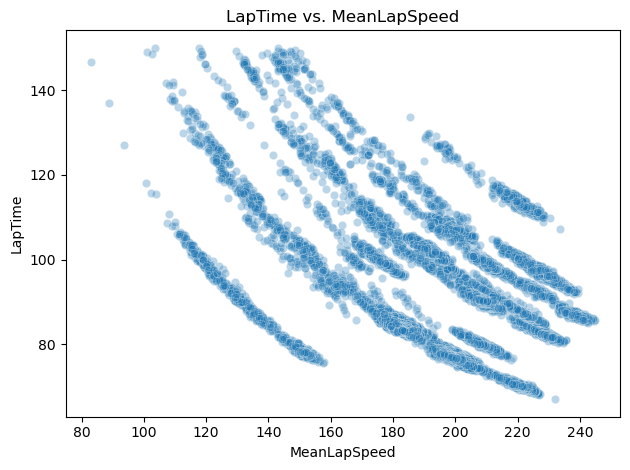

C:\Users\Patryk\AppData\Local\Temp\ipykernel_11516\983413460.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[col]) or X[col].nunique() < 10:


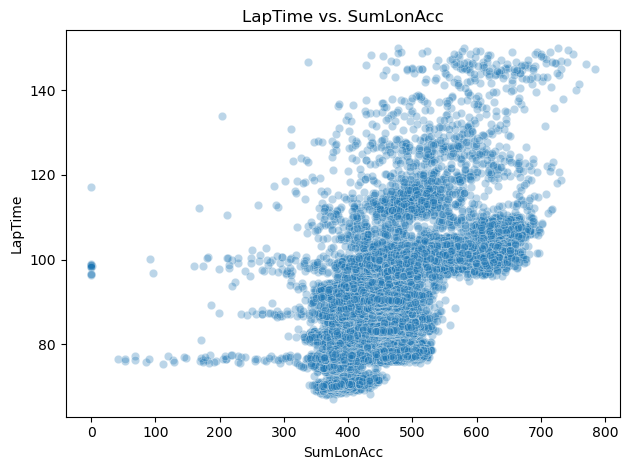

In [ ]:
def plot_all_features_vs_target(X : pd.DataFrame, y : pd.DataFrame, target_name : str ='LapTime') -> None:

    for i, col in enumerate(X.columns):
        if pd.api.types.is_categorical_dtype(X[col]) or X[col].nunique() < 10:
            sns.boxplot(x=X[col], y=y)
        else:
            sns.scatterplot(x=X[col], y=y, alpha=0.3)
        
        plt.xlabel(col)
        plt.ylabel(target_name)
        plt.title(f"{target_name} vs. {col}")

        plt.tight_layout()
        plt.show()

plot_all_features_vs_target(X[['TyreLife','SumLatAcc','MeanLapSpeed','SumLonAcc']],y)

In [ ]:
categorical_cols = ['Compound', 'Driver', 'Track']

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Scale all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [338]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1221)

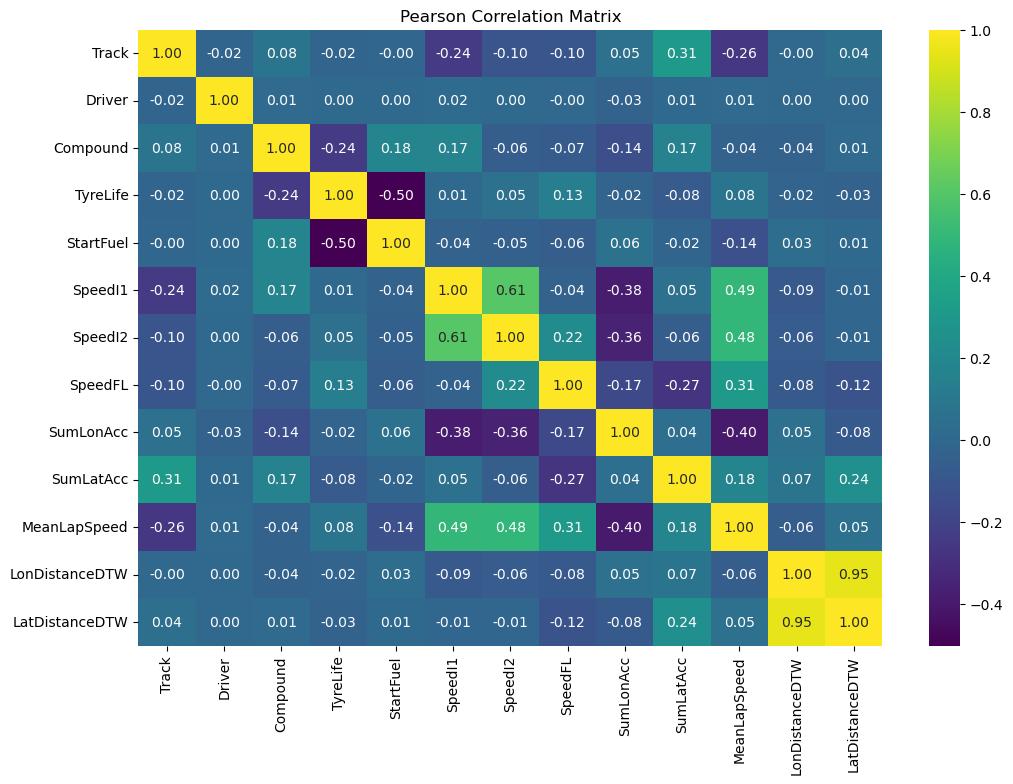

In [339]:
plt.figure(figsize=(12,8))

corr = X_train.corr()

sns.heatmap(corr, annot=True, cmap='viridis', fmt=".2f")

plt.title("Pearson Correlation Matrix")

plt.show()

In [340]:
X_train = X_train.astype('float64')

In [341]:
X_train.dtypes

Track             float64
Driver            float64
Compound          float64
TyreLife          float64
StartFuel         float64
SpeedI1           float64
SpeedI2           float64
SpeedFL           float64
SumLonAcc         float64
SumLatAcc         float64
MeanLapSpeed      float64
LonDistanceDTW    float64
LatDistanceDTW    float64
dtype: object

In [ ]:
X_vif = sm.add_constant(X_train)
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]

In [343]:
print("\nVariance Inflation Factors:")
print(vif_data)


Variance Inflation Factors:
           feature        VIF
0            const   1.000114
1            Track   1.362091
2           Driver   1.002373
3         Compound   1.237989
4         TyreLife   1.402656
5        StartFuel   1.371662
6          SpeedI1   2.210588
7          SpeedI2   1.947201
8          SpeedFL   1.458814
9        SumLonAcc   1.601194
10       SumLatAcc   1.952790
11    MeanLapSpeed   2.168518
12  LonDistanceDTW  16.731312
13  LatDistanceDTW  17.729101


In [344]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_vif = sm.add_constant(X_train.drop(columns='LatDistanceDTW'))
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]

In [345]:
print("\nVariance Inflation Factors:")
print(vif_data)


Variance Inflation Factors:
           feature       VIF
0            const  1.000107
1            Track  1.361394
2           Driver  1.001562
3         Compound  1.237828
4         TyreLife  1.402572
5        StartFuel  1.370176
6          SpeedI1  2.210223
7          SpeedI2  1.945294
8          SpeedFL  1.440718
9        SumLonAcc  1.344104
10       SumLatAcc  1.523417
11    MeanLapSpeed  2.139326
12  LonDistanceDTW  1.025470


In [346]:
X_train = X_train.drop(columns='LatDistanceDTW')

In [347]:
X_test = X_test.drop(columns='LatDistanceDTW')

In [348]:
X_train = X_train.drop(columns=['Driver', 'Track'])

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


X_stats = sm.add_constant(X_train)
model1 = sm.OLS(y_train, X_stats).fit()
print("\nModel Summary (OLS):")

print(model1.summary())


Model Summary (OLS):
                            OLS Regression Results                            
Dep. Variable:                LapTime   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     1573.
Date:               pon., 09 cze 2025   Prob (F-statistic):               0.00
Time:                        13:11:09   Log-Likelihood:                -57349.
No. Observations:               15603   AIC:                         1.147e+05
Df Residuals:                   15592   BIC:                         1.148e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             91.3

In [309]:
X_train_nl = X_train.copy()
X_train_nl['TyreLife2'] = X_train_nl['TyreLife'] ** 2
X_train_nl['SumLonAcc2'] = X_train_nl['SumLonAcc'] ** 2
X_train_nl['SumLatAcc2'] = X_train_nl['SumLatAcc'] ** 2
X_train_nl['MeanLapSpeed2'] = X_train_nl['MeanLapSpeed'] ** 2

In [311]:
X_train_nl

,Track,Driver,Compound,TyreLife,StartFuel,SpeedI1,SpeedI2,SpeedFL,SumLonAcc,SumLatAcc,MeanLapSpeed,LonDistanceDTW,TyreLife2,SumLonAcc2,SumLatAcc2,MeanLapSpeed2
0,-0.429962,0.668246,1.591602,-0.083871,1.048807,1.001114,0.255415,-0.593630,-0.957792,1.272023,0.993911,-0.577349,0.007034,0.917366,1.618043,0.987860
1,-1.213699,-1.494344,-0.963415,-0.878294,0.626729,-1.120109,-0.585765,1.753893,2.471510,-0.523458,0.157760,0.248262,0.771401,6.108363,0.274009,0.024888
2,-0.743457,-1.030932,1.591602,0.611250,-1.520988,1.086820,0.061297,1.222906,-1.025887,0.094586,0.215612,-0.534361,0.373626,1.052444,0.008947,0.046488
3,0.353775,0.822717,-0.963415,0.611250,-0.740000,0.701143,0.665221,-0.537736,-0.136572,-0.936869,-0.500842,-0.336654,0.373626,0.018652,0.877724,0.250843
4,0.667269,0.668246,-0.963415,-0.481083,1.301333,-1.377226,-1.405376,-0.230322,0.135787,-0.345653,-1.856279,-0.151602,0.231440,0.018438,0.119476,3.445772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15598,-1.370447,1.131658,-0.963415,-0.778991,-0.349506,0.872555,-0.391646,0.216825,-1.105705,-1.338143,0.945926,-0.459818,0.606828,1.222583,1.790626,0.894776
15599,-1.213699,0.977187,-0.963415,1.306370,-0.671664,-1.462932,-0.974002,1.809787,2.192553,-0.629119,0.052231,-0.017078,1.706603,4.807288,0.395791,0.002728
15600,-0.743457,0.050363,1.591602,0.214038,-1.569800,1.001114,0.018159,1.167013,-0.946030,-0.066712,0.198046,-0.001479,0.045812,0.894973,0.004450,0.039222
15601,-1.370447,1.595070,-0.963415,1.703582,-1.667424,1.343938,-0.262234,0.216825,-0.604556,-1.292821,0.837582,-0.364997,2.902192,0.365488,1.671387,0.701543


In [ ]:
X_train_nl = X_train_nl.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


X_stats = sm.add_constant(X_train_nl)
model2 = sm.OLS(y_train, X_stats).fit()
print("\nModel Summary (OLS):")

print(model2.summary())


Model Summary (OLS):
                            OLS Regression Results                            
Dep. Variable:                LapTime   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     1994.
Date:               pon., 09 cze 2025   Prob (F-statistic):               0.00
Time:                        13:09:58   Log-Likelihood:                -54784.
No. Observations:               15603   AIC:                         1.096e+05
Df Residuals:                   15588   BIC:                         1.097e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             85.4

In [ ]:
X_vif = sm.add_constant(X_train)
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]
print("\nVariance Inflation Factors:")
print(vif_data)


Variance Inflation Factors:
           feature       VIF
0            const  1.000107
1            Track  1.361394
2           Driver  1.001562
3         Compound  1.237828
4         TyreLife  1.402572
5        StartFuel  1.370176
6          SpeedI1  2.210223
7          SpeedI2  1.945294
8          SpeedFL  1.440718
9        SumLonAcc  1.344104
10       SumLatAcc  1.523417
11    MeanLapSpeed  2.139326
12  LonDistanceDTW  1.025470


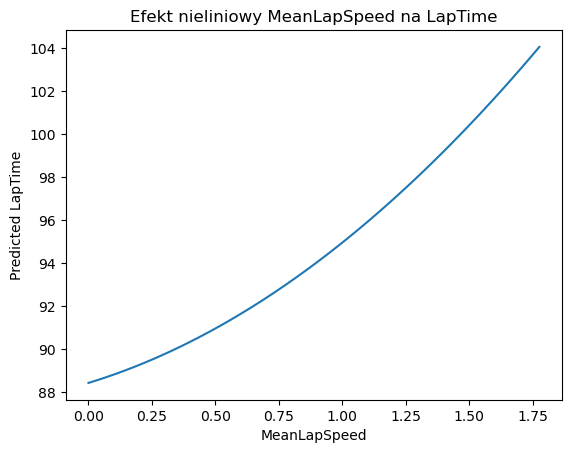

In [ ]:
X_mean = X_train_nl.mean()

tyre_life_vals = np.linspace(0, X_train_nl['MeanLapSpeed'].max(), 100)

preds = (model2.params['const'] +
         model2.params['MeanLapSpeed'] * tyre_life_vals +
         model2.params['MeanLapSpeed2'] * tyre_life_vals**2 +
         sum(model2.params[col] * X_mean[col] for col in X_train_nl.columns if col not in ['MeanLapSpeed', 'MeanLapSpeed2']))

plt.plot(tyre_life_vals, preds)
plt.xlabel('MeanLapSpeed')
plt.ylabel('Predicted LapTime')
plt.title('Efekt nieliniowy MeanLapSpeed na LapTime')
plt.show()

In [ ]:
X_test_const = sm.add_constant(X_test) 
y_pred_1 = model1.predict(X_test_const)
mse_1 = mean_squared_error(y_test, y_pred_1)

X_test_nl = X_test.copy()
X_test_nl['TyreLife2'] = X_test_nl['TyreLife'] ** 2
X_test_nl['SumLonAcc2'] = X_test_nl['SumLonAcc'] ** 2
X_test_nl['SumLatAcc2'] = X_test_nl['SumLatAcc'] ** 2
X_test_nl['MeanLapSpeed2'] = X_test_nl['MeanLapSpeed'] ** 2

X_test_const = sm.add_constant(X_test_nl)

y_pred_2 = model2.predict(X_test_const)
mse_2 = mean_squared_error(y_test, y_pred_2)

print(f"Model 1 MSE (linear): {mse_1:.3f}")
print(f"Model 1 R2: {r2_score(y_test, y_pred_1):.4f}")
print(f"Model 2 MSE (non-linear): {mse_2:.3f}")
print(f"Model 2 R2: {r2_score(y_test, y_pred_2):.4f}")

Model 1 MSE (linear): 90.592
Model 1 R2: 0.5075
Model 2 MSE (non-linear): 66.058
Model 2 R2: 0.6409


In [ ]:
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return -scores.mean()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-06-09 13:02:26,116] A new study created in memory with name: no-name-0617c9e3-ebe9-46e7-8faa-68b59199c8d2
[I 2025-06-09 13:02:26,592] Trial 0 finished with value: 11.178768347683356 and parameters: {'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 0 with value: 11.178768347683356.
[I 2025-06-09 13:02:26,723] Trial 1 finished with value: 22.821836217910306 and parameters: {'max_depth': 19, 'min_samples_split': 14, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 0 with value: 11.178768347683356.
[I 2025-06-09 13:02:26,884] Trial 2 finished with value: 59.86555025578527 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 11.178768347683356.
[I 2025-06-09 13:02:27,072] Trial 3 finished with value: 16.411985665248515 and parameters: {'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 w

In [288]:
best_params = study.best_params
print("Best parameters:", best_params)

model_tree = DecisionTreeRegressor(**best_params, random_state=42)
model_tree.fit(X_train, y_train)

y_pred_tree = model_tree.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
print(f"Decision Tree MSE: {mse_tree:.3f}")

Best parameters: {'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None}
Decision Tree MSE: 10.741


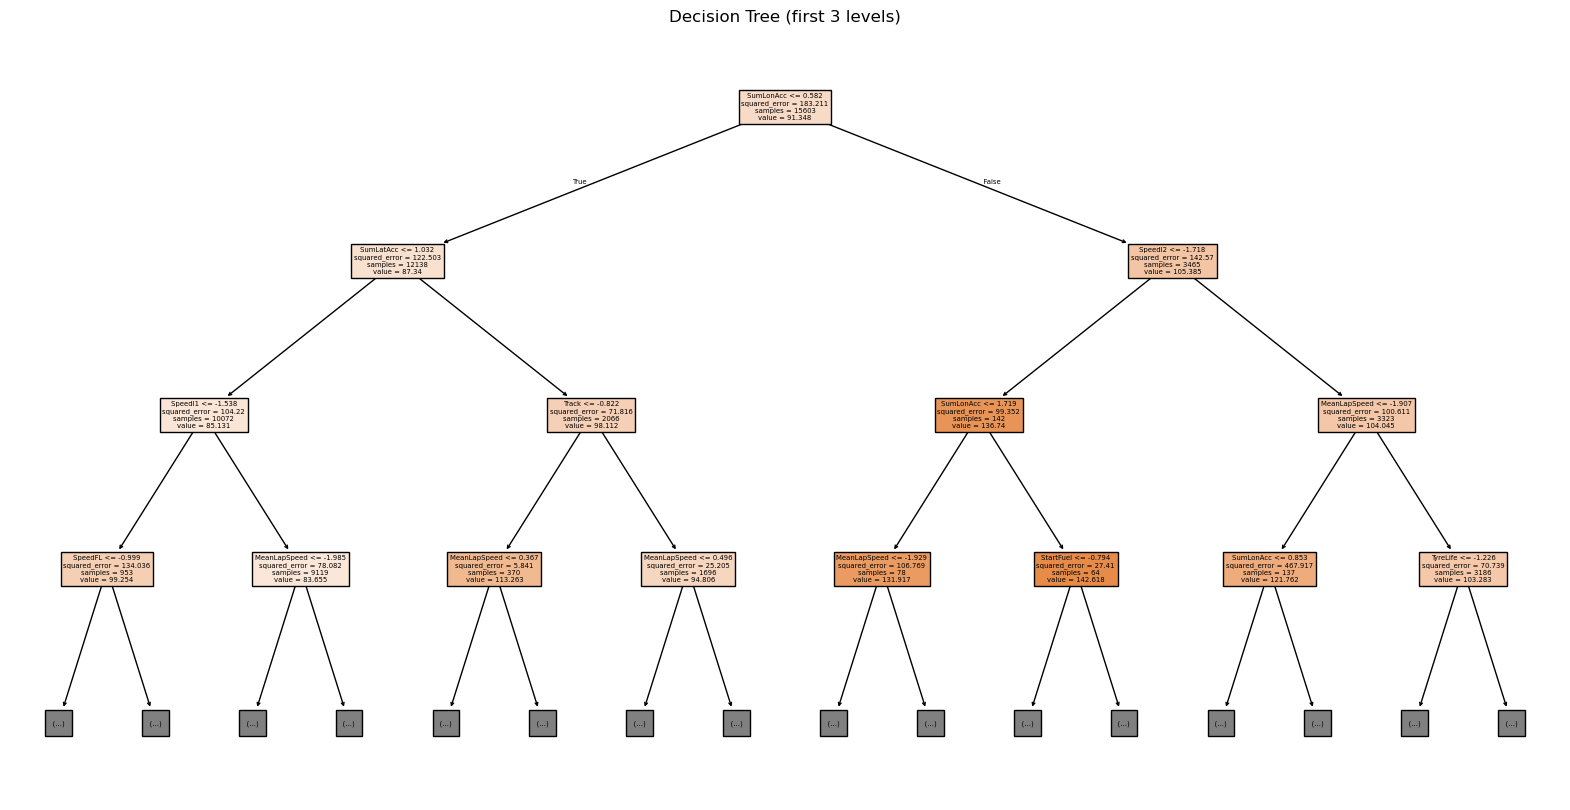

In [289]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(model_tree, feature_names=X_train.columns, filled=True, max_depth=3)
plt.title("Decision Tree (first 3 levels)")
plt.show()

Best Decision Tree parameters: {'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None}
Decision Tree MSE: 10.741
Non-Linear model MSE: 66.058

Porównanie MSE:
 - Non-Linear model: 66.058
 - Decision Tree: 10.741

Feature Importances:
           Feature  Importance
8        SumLonAcc    0.330565
10    MeanLapSpeed    0.135524
9        SumLatAcc    0.123202
6          SpeedI2    0.114916
5          SpeedI1    0.099587
0            Track    0.099075
7          SpeedFL    0.036170
11  LonDistanceDTW    0.033414
3         TyreLife    0.017037
4        StartFuel    0.008010
2         Compound    0.002370
1           Driver    0.000129


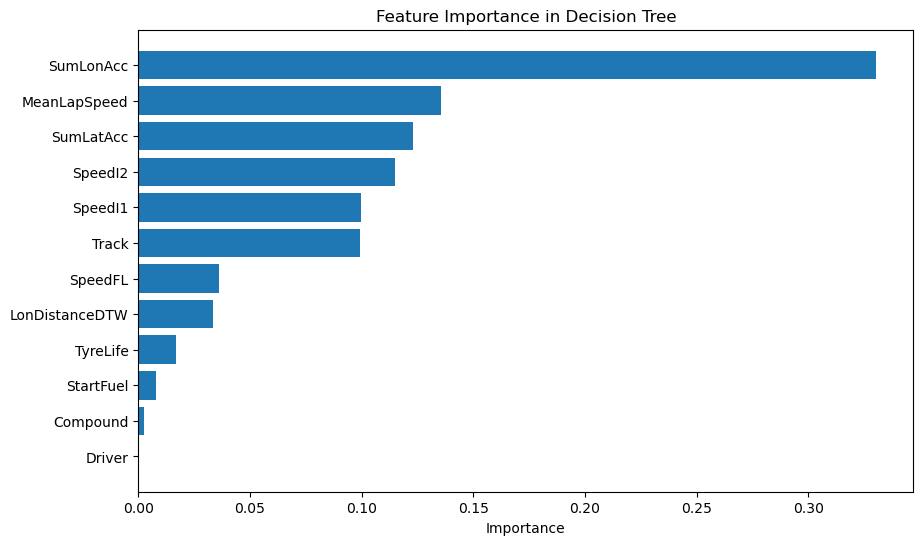

In [ ]:
features = [
    'Track', 'Driver', 'Compound', 'TyreLife', 'StartFuel',
    'SpeedI1', 'SpeedI2', 'SpeedFL', 'SumLonAcc', 'SumLatAcc',
    'MeanLapSpeed', 'LonDistanceDTW'
]

X_train_tree = X_train[features]
X_test_tree = X_test[features]

best_params = study.best_params
print("Best Decision Tree parameters:", best_params)

model_tree = DecisionTreeRegressor(**best_params, random_state=42)
model_tree.fit(X_train_tree, y_train)

y_pred_tree = model_tree.predict(X_test_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
print(f"Decision Tree MSE: {mse_tree:.3f}")

y_pred_ols = model2.predict(X_test_const)
mse_ols = mean_squared_error(y_test, y_pred_ols)
print(f"Non-Linear model MSE: {mse_ols:.3f}")

print(f"\nPorównanie MSE:\n - Non-Linear model: {mse_ols:.3f}\n - Decision Tree: {mse_tree:.3f}")

importances = model_tree.feature_importances_
fi_df = pd.DataFrame({'Feature': features, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(fi_df)

plt.figure(figsize=(10,6))
plt.barh(fi_df['Feature'], fi_df['Importance'])
plt.xlabel("Importance")
plt.title("Feature Importance in Decision Tree")
plt.gca().invert_yaxis()
plt.show()


In [255]:
print(X.columns.tolist())

['Track', 'Driver', 'Compound', 'TyreLife', 'StartFuel', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SumLonAcc', 'SumLatAcc', 'MeanLapSpeed', 'LonDistanceDTW', 'LatDistanceDTW']
